In [8]:
import os
import cv2
from insightface.app import FaceAnalysis
from insightface.utils import face_align
import torch
from diffusers import StableDiffusionPipeline, DDIMScheduler, AutoencoderKL
from PIL import Image
from rembg import remove

from ip_total.ip_adapter_total import IPAdapterTotal

In [9]:
# Dowmload the model files manually from the HuggingFace and put them in the models dir, or use the  comments after each line to download automatically. 
base_model_path = "models\majicmix-realistic-v7" # pagebrain/majicmix-realistic-v7
image_encoder_path_faceid = "models/CLIP-ViT-H-14-laion2B-s32B-b79K" # laion/CLIP-ViT-H-14-laion2B-s32B-b79K
image_encoder_path_general = "models/image_encoder" # h94/IP-Adapter
vae_model_path = "models/sd-vae-ft-mse" # stabilityai/sd-vae-ft-mse
ip_total_ckpt = "models/aaa_ip_total.bin" # vvvictor/AAA
device = "cuda"

In [10]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

In [11]:
# load SD pipeline
noise_scheduler = DDIMScheduler(
        num_train_timesteps=1000,
        beta_start=0.00085,
        beta_end=0.012,
        beta_schedule="scaled_linear",
        clip_sample=False,
        set_alpha_to_one=False,
        steps_offset=1,
)
vae  = AutoencoderKL.from_pretrained(vae_model_path).to(dtype=torch.float16)
pipe = StableDiffusionPipeline.from_pretrained(
    base_model_path,
    torch_dtype=torch.float16,
    scheduler=noise_scheduler,
    vae=vae,
    feature_extractor=None,
    safety_checker=None
)

Loading pipeline components...: 100%|██████████| 5/5 [00:00<00:00, 19.79it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [12]:
# load ip-adapter
ip_model = IPAdapterTotal(pipe, 
                          image_encoder_path_faceid=image_encoder_path_faceid,
                          image_encoder_path_general=image_encoder_path_general,
                          ip_ckpt=ip_total_ckpt,
                          device=device)

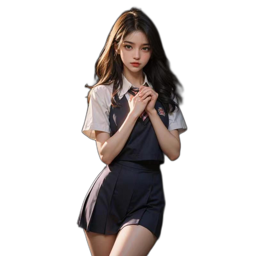

In [14]:
# preprocess teplate images
image_cloth = Image.open("data/input/cloth_img.jpg")
image_cloth_rmbg = remove(image_cloth, bgcolor=[255,255,255,255])
image_cloth_rmbg = image_cloth_rmbg.convert("RGB").resize((256, 256))

image_cloth_rmbg

C:\Users\kei\AppData\Roaming\Python\Python310\site-packages\onnxruntime\capi\onnxruntime_inference_collection.py:69: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\kei/.insightface\models\buffalo_l\1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\kei/.insightface\models\buffalo_l\2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\kei/.insightface\models\buffalo_l\det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\kei/.insightface\models\buffalo_l\genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\kei/.insightface\models\buffalo_l\w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
se

C:\Users\kei\AppData\Roaming\Python\Python310\site-packages\insightface\utils\transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


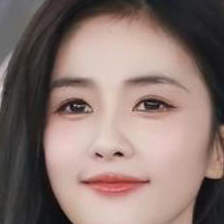

In [15]:
# preprocess face image
face_app = FaceAnalysis(name="buffalo_l", providers=['CUDAExecutionProvider', 'CPUExecutionProvider'])
face_app.prepare(ctx_id=0, det_size=(640, 640))

img_path = "data/input/face_img.jpg"
image = cv2.imread(img_path)
faces = face_app.get(image)

faceid_embeds = torch.from_numpy(faces[0].normed_embedding).unsqueeze(0)
face_image = face_align.norm_crop(image, landmark=faces[0].kps, image_size=224) # you can also segment the face
face_image = cv2.cvtColor(face_image, cv2.COLOR_BGR2RGB)
face_image = Image.fromarray(face_image)
face_image

100%|██████████| 30/30 [00:03<00:00,  7.93it/s]


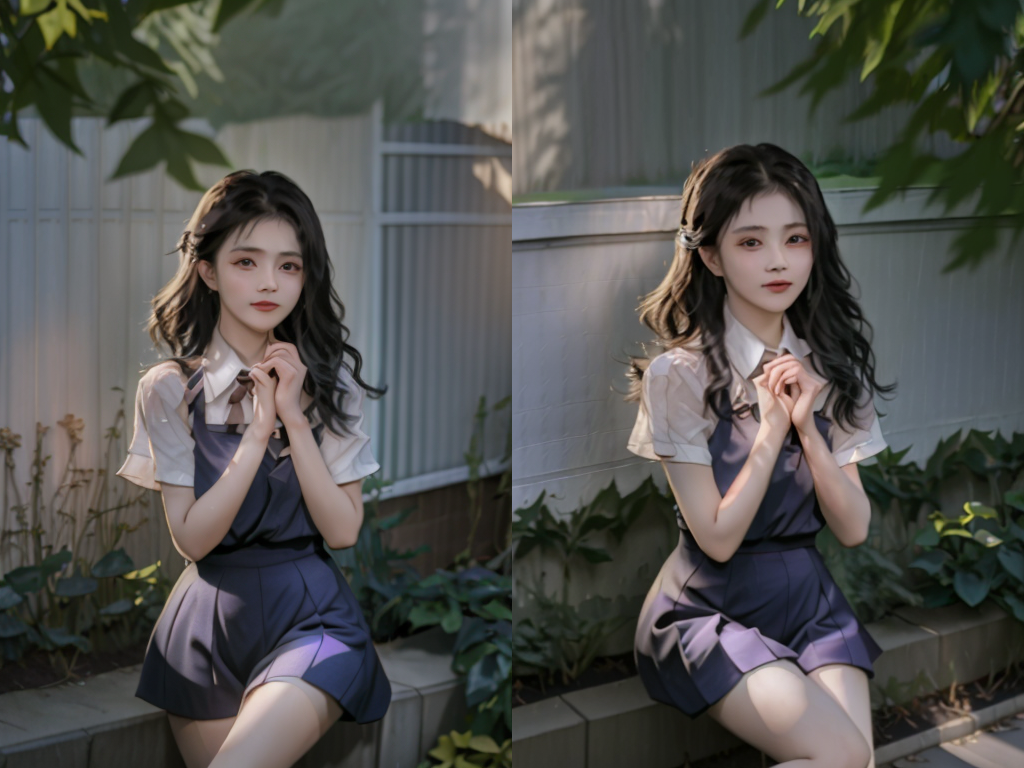

In [16]:
# generate
prompt = "In a garden,1girl, high quality, masterpiece, raw photo,realistic"
negative_prompt = "monochrome, lowres, bad anatomy, worst quality, low quality, blurry"
scale_faceid = 0.5
scale_general = 0.6
width=512
height=768

images = ip_model.generate(
            prompt=prompt, negative_prompt=negative_prompt,
            scale_faceid=scale_faceid, 
            scale_general=scale_general, 
            face_image=face_image, 
            faceid_embeds=faceid_embeds, 
            template_img=image_cloth_rmbg,
            width=width, height=height, 
            num_samples=2,num_inference_steps=30, seed=21837
        )

# show result
grid = image_grid(images, 1, 2)
grid